### The Walmart challenge: Modelling weekly sales
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview


## Understanding the problem and defining a success metric

The problem is quite straightforward. Data from Walmart stores accross the US is given, and it is up to us to forecast their weekly sales. The data is already split into a training and a test set, and we want to fit a model to the training data that is able to forecast those weeks sales as accurately as possible. In fact, our metric of interest will be the [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error). 

The metric is not very complicated. The further away from the actual outcome our forecast is, the harder it will be punished. Optimally, we exactly predict the weekly sales. This of course is highly unlikely, but we must try to get as close as possible. The base case of our model will be a simple linear regression baseline, which gave a MSE of 



## Load and explore data
Before we do anything, lets import some packages.

In [1]:
#Really need these
import pandas as pd 
import numpy as np
from numpy import *


#Handy for debugging
import gc
import time
import warnings
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Do some statistics
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse


## Performance measures
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Prepare functions
I initialize my functions in the beginning of the script to make the whole seem cleaner..

In [14]:
#Merge info
def mergeData(df):
    features =pd.read_csv('./data/features.csv')
    storesdata =pd.read_csv('./data/stores.csv')
    df = pd.merge(df, features, on=['Store','Date','IsHoliday'],
                  how='inner')
    df = pd.merge(df, storesdata, on=['Store'],
                  how='inner')
    return df

#http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html
def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()
def binary(movement):
    """
    Converts percent change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    direction = np.empty(movement.shape[0])
    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

def scatterplots(feature, label, dot_size):
    x = feature
    y = df['Weekly_Sales']
    plt.scatter(x, y, s=dot_size)
    plt.ylabel('sales')
    plt.xlabel(label)
    plt.show()

In [3]:
train = mergeData(pd.read_csv('./data/train.csv'))
test = mergeData(pd.read_csv('./data/test.csv'))
train['Split'] = 'Train'
test['Split'] = 'Test'
test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
1,1,2,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
2,1,3,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
3,1,4,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test
4,1,5,2012-11-02,False,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,A,151315,Test


In order to efficiently modify our data, we merge the two datasets for now. We also keep track of the length of our training set so we know how to split it later.

In [4]:
t_len = len(train) # Get number of training examples
df = pd.concat([train,test],axis=0) # Join train and test
df.tail() # Get an overview of the data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
115059,45,93,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115060,45,94,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115061,45,95,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115062,45,97,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115063,45,98,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test


Let's get a clearer image of what our data actually looks like with the describe function. This will give use summary statistics of our numerical variables.

In [5]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,536634.000000,536634.000000,421570.000000,536634.000000,536634.000000,265596.000000,197685.000000,242326.000000,237143.000000,266496.000000,498472.000000,498472.000000,536634.000000
mean,22.208621,44.277301,15981.258123,58.771762,3.408310,7438.004144,3509.274827,1857.913525,3371.556866,4324.021158,172.090481,7.791888,136678.550960
std,12.790580,30.527358,22711.183519,18.678716,0.430861,9411.341379,8992.047197,11616.143274,6872.281734,13549.262124,39.542149,1.865076,61007.711799
min,1.000000,1.000000,-4988.940000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.000000
25%,11.000000,18.000000,2079.650000,45.250000,3.041000,2114.640000,72.500000,7.220000,336.240000,1570.112500,132.521867,6.623000,93638.000000
50%,22.000000,37.000000,7612.030000,60.060000,3.523000,5126.540000,385.310000,40.760000,1239.040000,2870.910000,182.442420,7.795000,140167.000000
75%,33.000000,74.000000,20205.852500,73.230000,3.744000,9303.850000,2392.390000,174.260000,3397.080000,5012.220000,213.748126,8.549000,202505.000000
max,45.000000,99.000000,693099.360000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.000000


Since we are in the Netherlands, and we don't understand Fahrenheit, let's do a quick change there.

In [6]:
df['Temperature'] = (df['Temperature'] - 32) * 5/9

In [9]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
0,1,1,2010-02-05,24924.50,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,Train
1,1,2,2010-02-05,50605.27,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,Train
2,1,3,2010-02-05,13740.12,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,Train
3,1,4,2010-02-05,39954.04,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,Train
4,1,5,2010-02-05,32229.38,False,5.727778,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,93,2013-07-26,NaN,False,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115060,45,94,2013-07-26,NaN,False,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115061,45,95,2013-07-26,NaN,False,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test
115062,45,97,2013-07-26,NaN,False,24.477778,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221,Test


Although there is not a large variety of variables, we can definitely work with this. In the next section, we will clean the data set, engineer some new features and add dummy variables. For now, let's try to find any obvious relations between our variables to get a feeling for the data. We begin with a correlation matrix.


<Axes: >

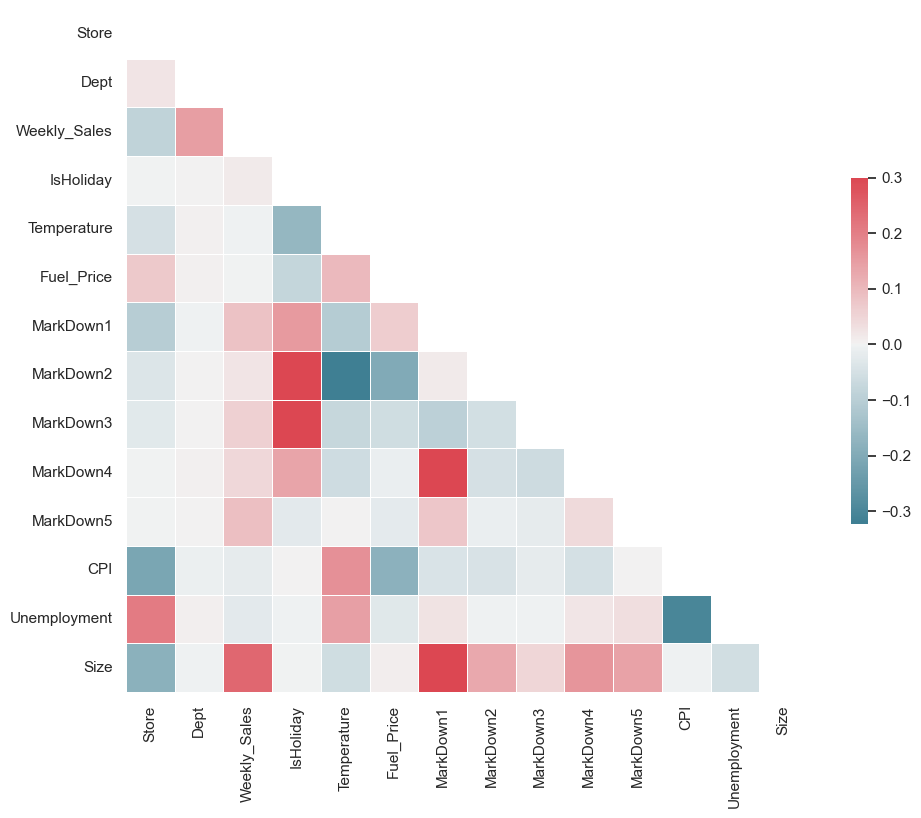

In [11]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Most of what we see in the correlation table is of little surprise. Discounts are correlated and higher unemployment means lower Consumer Price Index. More interestingly, it appears that higher department numbers have higher sales. Maybe because they are newer? Also, larger stores generate more sales, discounts generally generate higher sales values and larger unemployment result in a bit fewer sales. Unfortunately, there appears to be little relationship between holidays, temperatures or fuelprices with our weekly sales.

Next up, let's plot some of these relationships to get a clearer image.

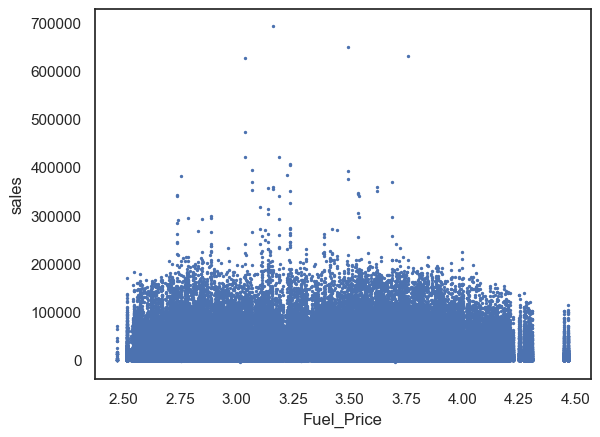

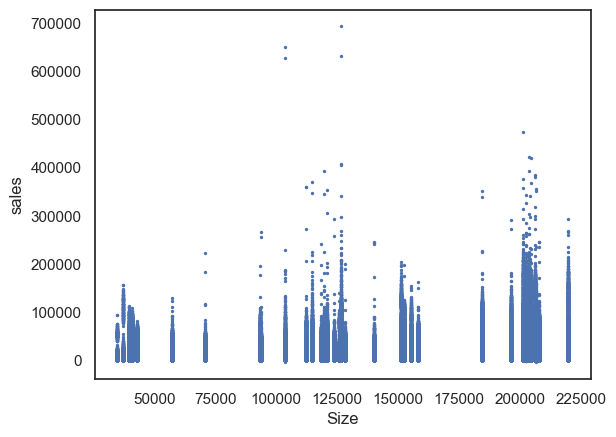

In [16]:


headers = list(df)
labels = headers
scatterplots(df['Fuel_Price'], 'Fuel_Price', dot_size=2)
scatterplots(df['Size'], 'Size', dot_size=2)
#scatterplots(df['Temperature'], 'Temperature')
#scatterplots(df['Unemployment'], 'Unemployment')
#scatterplots(df['IsHoliday'], 'IsHoliday')
#scatterplots(df['Type'], 'Type')

From this plot, we notice that type C stores have fewer sales in general and holidays clearly show more sales.Although no further relationships appear evident from this analysis, there appears to be some outliers in our data. Let's take a bit of a closer look at these.

In [17]:
df.loc[df['Weekly_Sales'] >300000]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
32594,4,72,2010-11-26,381072.11,True,8.933333,2.752,NaN,NaN,NaN,NaN,NaN,126.669267,7.127,A,205863,Train
36312,4,72,2011-11-25,385051.04,True,8.866667,3.225,561.45,137.88,83340.33,44.04,9239.23,129.836400,5.143,A,205863,Train
36557,4,7,2011-12-23,318422.01,False,2.177778,3.103,2461.94,69.05,2938.24,52.00,4396.76,129.984548,5.143,A,205863,Train
51826,6,72,2010-11-26,342578.65,True,18.772222,2.735,NaN,NaN,NaN,NaN,NaN,213.267296,7.007,A,202505,Train
55545,6,72,2011-11-25,326866.60,True,17.100000,3.236,429.03,171.88,83192.81,15.00,986.23,220.041741,6.551,A,202505,Train
90645,10,72,2010-11-26,693099.36,True,12.961111,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,Train
90886,10,7,2010-12-24,406988.63,False,13.922222,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512,Train
90936,10,72,2010-12-24,404245.03,False,13.922222,3.236,NaN,NaN,NaN,NaN,NaN,126.983581,9.003,B,126512,Train
94393,10,72,2011-11-25,630999.19,True,15.933333,3.760,174.72,329.00,141630.61,79.00,1009.98,129.836400,7.874,B,126512,Train
94634,10,7,2011-12-23,341308.00,False,9.088889,3.541,300.02,77.73,2432.01,108.37,4078.21,129.984548,7.874,B,126512,Train


It appears to be quite obvious. The end of November sees a lot of exceptionally large sales. This special day, better known as Black friday, causes sales to be on fire, and undoubtedly a dummy variable should be created for this day. Also, Christmas, appears here and there. Since it is not considered holiday, we will also make a dummy for this day. Let's see if we should consider some other special days as well.

In [18]:
df.loc[df['Weekly_Sales'] >240000,"Date"].value_counts()

Date
2010-11-26    23
2011-11-25    22
2010-12-24    14
2011-12-23     9
2010-12-17     2
2010-02-05     1
2011-08-26     1
Name: count, dtype: int64

Except for a handful spurious other dates, it appears that the two days before Christmas and Black Friday will do the job.



## Scrub the data and engineer features

### Missing values

We will start with filling in any blank values. There seem to be some missing values in the data. We have to make sure to deal with them before feeding anything into the network.

In [19]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales    115064
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI              38162
Unemployment     38162
Type                 0
Size                 0
Split                0
dtype: int64

We will do a bit of very basic feature engineering here by creating a feature which indicates whether a certain markdown was active at all.

In [20]:
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

We can probably safely fill all missing values with zero. For the markdowns this means that there was no markdown. For the weekly sales, the missing values are the ones we have to predict, so it does not really matter what we fill in there.

In [21]:
df.fillna(0, inplace=True)

### Dummy variables: Categorical Data

Now we have to create some dummy variebles for categorical data.

In [22]:
# Make sure we can later recognize what a dummy once belonged to
df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)
df['IsHoliday'] = 'IsHoliday_' + df['IsHoliday'].map(str)

In [23]:
# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])
holiday_dummies = pd.get_dummies(df['IsHoliday'])

### Dummy variables: Dates

From our earlier analysis, it has turned out that the date may be our best friend. As a general rule, it is a good start to already distinguish between different months in our model. This will create 12 dummy variables; one for each month.

In [24]:
df['DateType'] = [datetime.strptime(date, '%Y-%m-%d').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] = 'Month_' + df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

Next, let's look at 'special dates'. One variable for Christmas, one for black friday. We have to manually look up the dates of black friday if we want to extrapolate our data to other years, but for now we know: 26 - 11 - 2010 and 25 - 11 - 2011.

In [25]:
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, 12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
df['Black_Friday'] = 'Black_Friday_' + df['Black_Friday'].map(str)
df['Pre_christmas'] = 'Pre_christmas_' + df['Pre_christmas'].map(str)
Black_Friday_dummies = pd.get_dummies(df['Black_Friday'] )
Pre_christmas_dummies = pd.get_dummies(df['Pre_christmas'] )

In [26]:
# Add dummies
# We will actually skip some of these
#df = pd.concat([df,type_dummies,store_dummies,dept_dummies,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies,Month_dummies],axis=1)

df = pd.concat([df,holiday_dummies,Pre_christmas_dummies,Black_Friday_dummies],axis=1)

> ### Store median

We will take the store median in the available data as one of its properties

In [27]:
# Get dataframe with averages per store and department
medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
medians.head()

,Type,Dept,Store,Month,IsHoliday,Median Sales
0,Type_A,Dept_1,Store_1,Month_1,IsHoliday_False,17350.585
1,Type_A,Dept_1,Store_1,Month_10,IsHoliday_False,23388.030
2,Type_A,Dept_1,Store_1,Month_11,IsHoliday_False,19551.115
3,Type_A,Dept_1,Store_1,Month_11,IsHoliday_True,19865.770
4,Type_A,Dept_1,Store_1,Month_12,IsHoliday_False,39109.390


In [28]:
# Merge by type, store, department and month
df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])


In [29]:
# Fill NA
df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 

# Create a key for easy access

df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)


In [30]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False
1,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False
3,Store_1,Dept_1,2011-02-04,21665.76,IsHoliday_False,5.705556,2.989,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False
4,Store_1,Dept_1,2011-02-18,46845.87,IsHoliday_False,14.088889,3.045,0.0,0.0,0.0,...,Black_Friday_no,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False


### Lagged Variables

We will take a lagged variable of our store's previous weeks sales. To do so, we will first add a column with a one week lagged date, sort the data, and then match the lagged sales with the initial dataframe using the department and store number.

We begin by adding a column with a one week lag.

In [31]:
# Attach variable of last weeks time
df['DateLagged'] = df['DateType']- timedelta(days=7)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29
1,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19
3,Store_1,Dept_1,2011-02-04,21665.76,IsHoliday_False,5.705556,2.989,0.0,0.0,0.0,...,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False,2011-01-28
4,Store_1,Dept_1,2011-02-18,46845.87,IsHoliday_False,14.088889,3.045,0.0,0.0,0.0,...,Pre_christmas_no,True,False,True,False,True,False,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False,2011-02-11


Next, we create a sorted dataframe.

In [32]:
# Make a sorted dataframe. This will allow us to find lagged variables much faster!
sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1, 1,1])
sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work

Loop over its rows and check at each step if the previous week's sales are available. If not, fill with store and department average, which we retrieved before.

In [33]:
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)): 
        sorted_df.at[index, 'LaggedSales'] = last['Weekly_Sales']
        sorted_df.at[index, 'LaggedAvailable'] = 1
    else:
        sorted_df.at[index,'LaggedSales'] = row['Median Sales'] # Fill with median
        sorted_df.at[index, 'LaggedAvailable']=0

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

0% loaded
9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


In [34]:
sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-12,24924.50,46039.49,37887.17
2,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
3,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
4,Dept_1,Store_1,2010-03-05,19403.54,21827.90,21280.40


Now, merge this new info with our existing dataset.

In [35]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], how = 'inner', on = ['Dept', 'Store','DateType'])

In [36]:
df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-02-05,23510.49,24924.50,23510.49
1,Dept_1,Store_1,2010-02-19,46039.49,41595.55,23510.49
2,Dept_1,Store_1,2010-02-26,41595.55,19403.54,23510.49
3,Dept_1,Store_1,2011-02-04,18461.18,21665.76,23510.49
4,Dept_1,Store_1,2011-02-18,37887.17,46845.87,23510.49


### Remove redundant items

We will take the store average in the available data as one of its properties

In [37]:
switch= 1

if(switch):
    df_backup = df
else:
    df=df_backup
    display(df_backup.head())

### Scale Variables

To make the job of our models easier in the next phase, we normalize our continous data. This is also called feature scaling.

In [38]:
#df['Unemployment'] = (df['Unemployment'] - df['Unemployment'].mean())/(df['Unemployment'].std())
##df['Temperature'] = (df['Temperature'] - df['Temperature'].mean())/(df['Temperature'].std())
#df['Fuel_Price'] = (df['Fuel_Price'] - df['Fuel_Price'].mean())/(df['Fuel_Price'].std())
#df['CPI'] = (df['CPI'] - df['CPI'].mean())/(df['CPI'].std())
#df['MarkDown1'] = (df['MarkDown1'] - df['MarkDown1'].mean())/(df['MarkDown1'].std())
#df['MarkDown2'] = (df['MarkDown2'] - df['MarkDown2'].mean())/(df['MarkDown2'].std())
#df['MarkDown3'] = (df['MarkDown3'] - df['MarkDown3'].mean())/(df['MarkDown3'].std())
#df['MarkDown4'] = (df['MarkDown4'] - df['MarkDown4'].mean())/(df['MarkDown4'].std())
#df['MarkDown5'] = (df['MarkDown5'] - df['MarkDown5'].mean())/(df['MarkDown5'].std())
#df['LaggedSales']= (df['LaggedSales'] - df['LaggedSales'].mean())/(df['LaggedSales'].std())

Now, let's change the variable to be forecasted to the difference from the median. Afterward, we can drop the weekly sales.

In [39]:
df['Difference'] = df['Median Sales'] - df['Weekly_Sales']

Let's have a look at our data set before running our actual models.

In [40]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,Store_1,Dept_1,2010-02-05,24924.50,IsHoliday_False,5.727778,2.572,0.0,0.0,0.0,...,False,True,False,23510.49,Type_ADept_1Store_12010-02-05IsHoliday_False,2010-01-29,23510.49,0.0,0.00,-1414.01
1,Store_1,Dept_1,2010-02-19,41595.55,IsHoliday_False,4.405556,2.514,0.0,0.0,0.0,...,False,True,False,23510.49,Type_ADept_1Store_12010-02-19IsHoliday_False,2010-02-12,46039.49,1.0,-22529.00,-18085.06
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.0,0.0,0.0,...,False,True,False,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19,41595.55,1.0,-18085.06,4106.95
3,Store_1,Dept_1,2011-02-04,21665.76,IsHoliday_False,5.705556,2.989,0.0,0.0,0.0,...,False,True,False,23510.49,Type_ADept_1Store_12011-02-04IsHoliday_False,2011-01-28,18461.18,1.0,5049.31,1844.73
4,Store_1,Dept_1,2011-02-18,46845.87,IsHoliday_False,14.088889,3.045,0.0,0.0,0.0,...,False,True,False,23510.49,Type_ADept_1Store_12011-02-18IsHoliday_False,2011-02-11,37887.17,1.0,-14376.68,-23335.38


<Axes: >

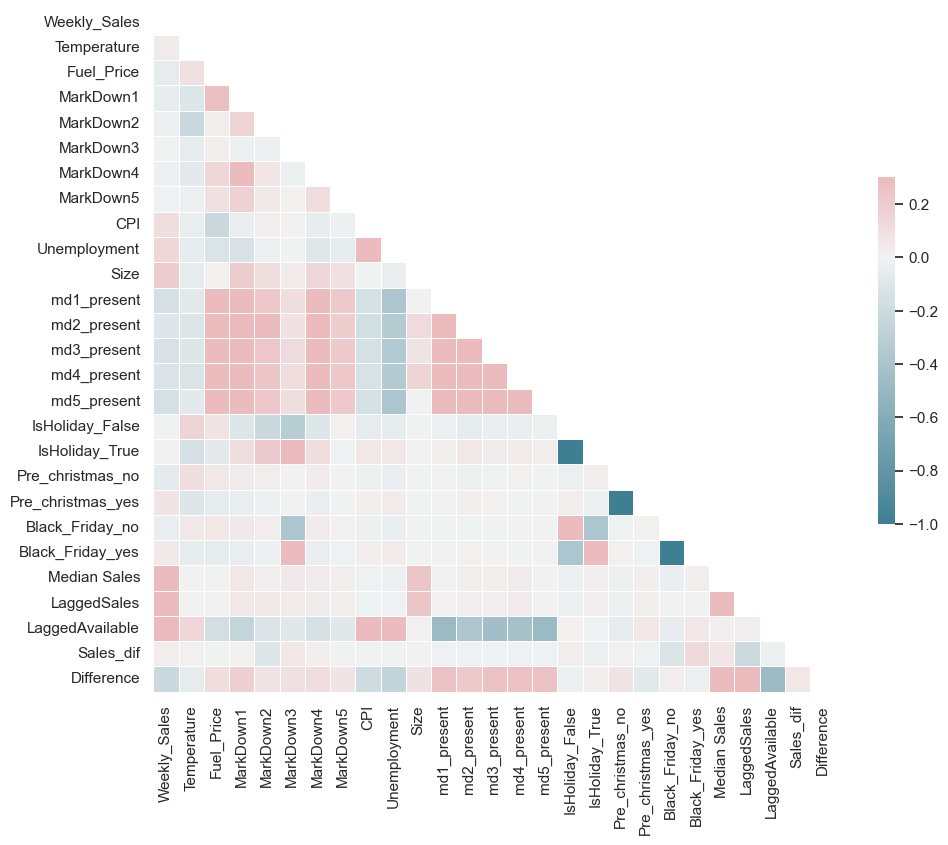

In [43]:
# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Select variables to include in model

In this section, we can change the variables we ultimately want to include in our model training. 

In [44]:
selector = [
    #'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
    
    
    
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',

    'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
display(df[selector].describe())
display(df[selector].head())

,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,LaggedSales,Sales_dif,LaggedAvailable
count,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000
mean,159.852499,3.408310,3681.287709,1292.745138,838.971725,1489.918846,2147.337557,136678.550960,14.873201,7.237779,15969.738804,-195.362035,0.773412
std,58.383773,0.430861,7593.883000,5714.136207,7860.456173,4865.593575,9789.902903,61007.711799,10.377064,2.691035,22689.394444,6003.550792,0.418624
min,0.000000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,34875.000000,-21.827778,0.000000,-1750.000000,-540263.085000,0.000000
25%,131.126667,3.041000,0.000000,0.000000,0.000000,0.000000,0.000000,93638.000000,7.361111,6.334000,2102.872500,-302.140000,1.000000
50%,140.439786,3.523000,0.000000,0.000000,0.000000,0.000000,0.000000,140167.000000,15.588889,7.567000,7608.320000,0.000000,1.000000
75%,212.303441,3.744000,5046.740000,118.730000,29.140000,906.450000,2852.190000,202505.000000,22.905556,8.512000,20182.661250,279.820000,1.000000
max,228.976456,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,219622.000000,38.861111,14.313000,693099.360000,579251.325000,1.000000


,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,Unemployment,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,211.096358,2.572,0.0,0.0,0.0,0.0,0.0,151315,5.727778,8.106,...,False,True,False,True,False,True,False,23510.49,0.00,0.0
1,211.289143,2.514,0.0,0.0,0.0,0.0,0.0,151315,4.405556,8.106,...,False,True,False,True,False,True,False,46039.49,-22529.00,1.0
2,211.319643,2.561,0.0,0.0,0.0,0.0,0.0,151315,8.127778,8.106,...,False,True,False,True,False,True,False,41595.55,-18085.06,1.0
3,212.566881,2.989,0.0,0.0,0.0,0.0,0.0,151315,5.705556,7.742,...,False,True,False,True,False,True,False,18461.18,5049.31,1.0
4,213.247885,3.045,0.0,0.0,0.0,0.0,0.0,151315,14.088889,7.742,...,False,True,False,True,False,True,False,37887.17,-14376.68,1.0


### Split data into training and test sets

Now we can split train test again and of course remove the trivial weekly sales data from the test set.

In [45]:
train = df.loc[df['Split']=='Train']
test = df.loc[df['Split']=='Test']
test.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
9,Store_1,Dept_1,2013-02-01,0.0,IsHoliday_False,13.588889,3.244,9290.91,1359.90,265.00,...,False,True,False,23510.49,Type_ADept_1Store_12013-02-01IsHoliday_False,2013-01-25,23510.49,0.0,0.0,23510.49
10,Store_1,Dept_1,2013-02-15,0.0,IsHoliday_False,9.811111,3.475,72937.29,6665.52,47.21,...,False,True,False,23510.49,Type_ADept_1Store_12013-02-15IsHoliday_False,2013-02-08,23510.49,0.0,0.0,23510.49
11,Store_1,Dept_1,2013-02-22,0.0,IsHoliday_False,10.138889,3.597,20107.75,3163.89,42.20,...,False,True,False,23510.49,Type_ADept_1Store_12013-02-22IsHoliday_False,2013-02-15,23510.49,0.0,0.0,23510.49
21,Store_1,Dept_2,2013-02-01,0.0,IsHoliday_False,13.588889,3.244,9290.91,1359.90,265.00,...,False,True,False,47080.12,Type_ADept_2Store_12013-02-01IsHoliday_False,2013-01-25,47080.12,0.0,0.0,47080.12
22,Store_1,Dept_2,2013-02-15,0.0,IsHoliday_False,9.811111,3.475,72937.29,6665.52,47.21,...,False,True,False,47080.12,Type_ADept_2Store_12013-02-15IsHoliday_False,2013-02-08,47080.12,0.0,0.0,47080.12


### Test - dev

Usually, model performance can be evaluated on the out-of-sample test set. However, since that data is not available, it may be wise to split our training set one more time in order to be able to test out of sample performance. Let's give up 20% of our training set for this sanity check development set.

In [46]:
# Set seed for reproducability 
np.random.seed(42)
X_train, X_dev, y_train, y_dev = train_test_split(train[selector], train['Difference'], test_size=0.2, random_state=42)
print(X_dev.shape)
print(y_dev.shape)

(84314, 24)
(84314,)


## Model selection

As usual, let's start off with all our imports.

### Adam optimizer with regularization

In our next model, we will stick with the relu activator, but replace the momentum with an Adam optimizer. Adaptive momumtum estimator uses exponentially weighted averages of the gradients to optimize its momentum.  However, since this method is known to overfit the model because of its fast decent, we will make use of a regulizer to avoid overfitting. The l2 regulizer adds the sum of absolute values of the weights to the loss function, thus discouraging large weights that overemphasize single observations.

In [47]:
neural = False
if neural:
    # Sequential model
    
    adam_regularized = Sequential()

    # First hidden layer now regularized
    adam_regularized.add(Dense(32,activation='relu',
                    input_dim=X_train.shape[1],
                    kernel_regularizer = regularizers.l2(0.01)))

    # Second hidden layer now regularized
    adam_regularized.add(Dense(16,activation='relu',
                       kernel_regularizer = regularizers.l2(0.01)))

    # Output layer stayed sigmoid
    adam_regularized.add(Dense(1,activation='linear'))

    # Setup adam optimizer
    adam_optimizer=keras.optimizers.Adam(lr=0.01,
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-08)

    # Compile the model
    adam_regularized.compile(optimizer=adam_optimizer,
                  loss='mean_absolute_error',
                  metrics=['acc'])

    # Train
    history_adam_regularized=adam_regularized.fit(X_train, y_train, # Train on training set
                                 epochs=10, # We will train over 1,000 epochs
                                 batch_size=2048, # Batch size 
                                 verbose=0) # Suppress Keras output
    adam_regularized.evaluate(x=X_dev,y=y_dev)

    # Plot network
    plt.plot(history_adam_regularized.history['loss'], label='Adam Regularized')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    y_pred_neural = adam_regularized.predict(X_dev)

### Random Forest

Train on random forest

In [50]:
#Random forest model specification
regr = RandomForestRegressor(n_estimators=20, max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features=1.0, 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      # min_impurity_split=None, 
                      bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

#Train on data
regr.fit(X_train, y_train.ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.5min finished


RandomForestRegressor(n_estimators=20, n_jobs=1, verbose=2)

### Model evaluation
 
 To evaluate the model, we will look at MAE and accuracy in terms of the number of times it correctly estimated an upward or downward deviation from the median.


In [51]:
y_pred_random = regr.predict(X_dev)

y_dev = y_dev.to_frame()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.9s finished


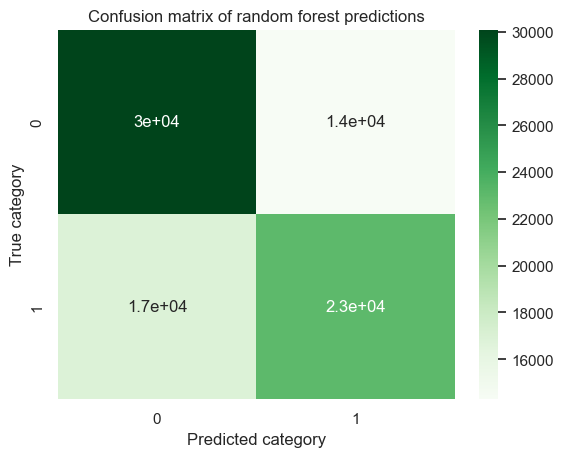

In [52]:
# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();

In [53]:
y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,Predicted
2,Store_1,Dept_1,2010-02-26,19403.54,IsHoliday_False,8.127778,2.561,0.00,0.00,0.00,...,True,False,23510.49,Type_ADept_1Store_12010-02-26IsHoliday_False,2010-02-19,41595.55,1.0,-18085.06,4106.95,-5168.62550
7,Store_1,Dept_1,2012-02-17,54060.10,IsHoliday_False,7.400000,3.510,9873.33,11062.27,9.80,...,True,False,23510.49,Type_ADept_1Store_12012-02-17IsHoliday_False,2012-02-10,36988.49,1.0,-13478.00,-30549.61,-12040.30750
14,Store_1,Dept_2,2010-02-26,44292.87,IsHoliday_False,8.127778,2.561,0.00,0.00,0.00,...,True,False,47080.12,Type_ADept_2Store_12010-02-26IsHoliday_False,2010-02-19,47928.89,1.0,-848.77,2787.25,58.93725
30,Store_1,Dept_3,2012-02-03,12485.78,IsHoliday_False,13.638889,3.360,34577.06,3579.21,160.53,...,True,False,11135.17,Type_ADept_3Store_12012-02-03IsHoliday_False,2012-01-27,10613.17,1.0,522.00,-1350.61,-236.67800
39,Store_1,Dept_4,2011-02-04,35870.49,IsHoliday_False,5.705556,2.989,0.00,0.00,0.00,...,True,False,36479.25,Type_ADept_4Store_12011-02-04IsHoliday_False,2011-01-28,32905.88,1.0,3573.37,608.76,-937.22325


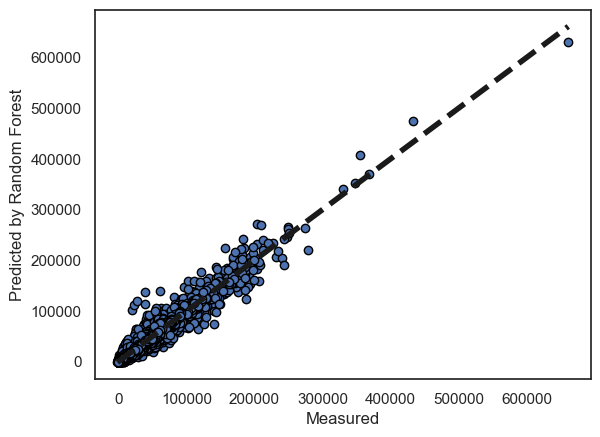

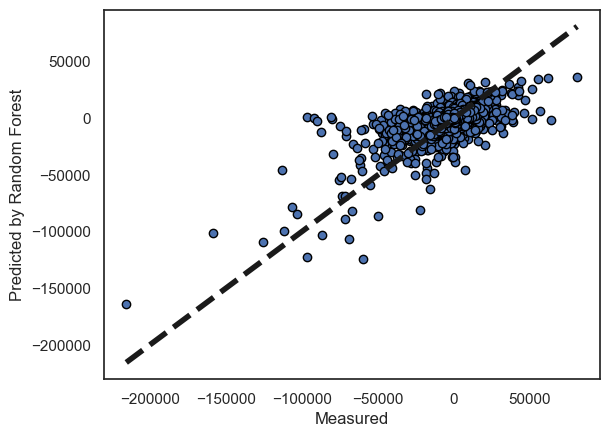

In [54]:
df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_pred_random,y_dev['Difference'].values,"Random Forest")

In [55]:
print("Medians: "+str(sum(abs(df_out['Difference']))/df_out.shape[0]))
print("Random Forest: "+str(sum(abs(df_out['Weekly_Sales']-df_out['prediction']))/df_out.shape[0]))

Medians: 1540.236027231539
Random Forest: 1349.2886474073105


Looks good! Let's train on our full data set to get the maximum amount of information in our model.

In [56]:
#Random forest model specification. Set n_estimators lower for faster performance
rf_model = RandomForestRegressor(n_estimators=80, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      #min_impurity_split=None,           
                      bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=0, warm_start=False)

#Train on data
rf_model.fit(train[selector], train['Difference'])

InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'squared_error', 'friedman_mse', 'absolute_error'}. Got 'mse' instead.

In [ ]:
#Use if large model skipped
#rf_model = regr

## Forecasting sales

After we have created our model, we can predict things with it on the test set

In [ ]:
final_y_prediction = rf_model.predict(test[selector])

In [ ]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()

Now we create the submission. Once you run the kernel you can download the submission from its outputs and upload it to the Kaggle InClass competition page.

In [ ]:
submission = pd.DataFrame({'id':pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Store']]).map(str) + '_' +
                           pd.Series([''.join(list(filter(str.isdigit, x))) for x in testfile['Dept']]).map(str)  + '_' +
                           testfile['Date'].map(str),
                          'Weekly_Sales':testfile['prediction']})
submission.head()

Check submission one more time

In [ ]:
#submission.to_csv('submission.csv',index=False)
import session_info
session_info.show(html=False)